# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.12KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

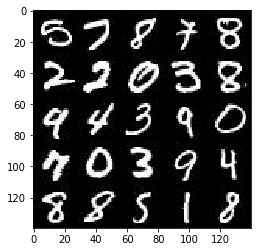

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

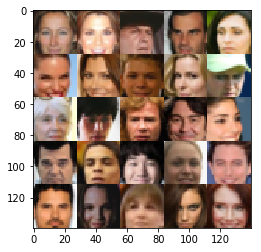

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')
    return inputs_real, inputs_z, learning_rate
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=0.8)    
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) 
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)  * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    show_every = 100
    print_every= 25
    n_images=25
    samples, losses = [], []
    steps = 0
    inputs_real, inputs_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, learning_rate: learning_rate_scalar})
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    print("Step {}/{} Epoch {}/{}...".format(steps, batch_size*epoch_count, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 25/128 Epoch 1/2... Discriminator Loss: 0.6178... Generator Loss: 2.0828
Step 50/128 Epoch 1/2... Discriminator Loss: 1.0426... Generator Loss: 1.9416
Step 75/128 Epoch 1/2... Discriminator Loss: 1.7828... Generator Loss: 0.4000
Step 100/128 Epoch 1/2... Discriminator Loss: 1.4963... Generator Loss: 1.5324


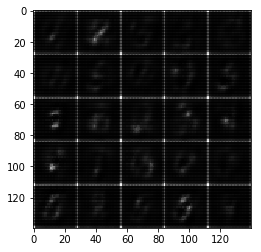

Step 125/128 Epoch 1/2... Discriminator Loss: 1.5485... Generator Loss: 0.4578
Step 150/128 Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 1.8846
Step 175/128 Epoch 1/2... Discriminator Loss: 1.6983... Generator Loss: 0.3784
Step 200/128 Epoch 1/2... Discriminator Loss: 1.8704... Generator Loss: 2.0620


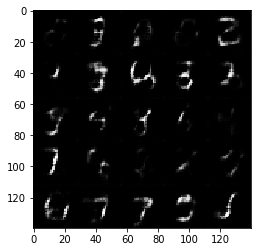

Step 225/128 Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 1.5275
Step 250/128 Epoch 1/2... Discriminator Loss: 2.1900... Generator Loss: 2.7267
Step 275/128 Epoch 1/2... Discriminator Loss: 1.5913... Generator Loss: 0.3901
Step 300/128 Epoch 1/2... Discriminator Loss: 1.4208... Generator Loss: 2.1871


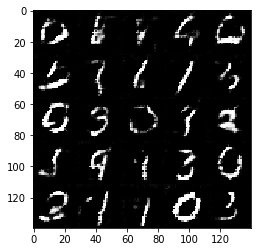

Step 325/128 Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 1.1640
Step 350/128 Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 0.6821
Step 375/128 Epoch 1/2... Discriminator Loss: 1.4877... Generator Loss: 0.4576
Step 400/128 Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 1.7014


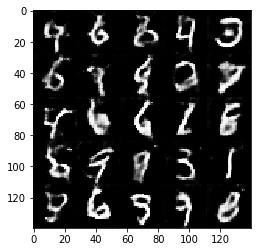

Step 425/128 Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 0.6051
Step 450/128 Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 1.8002
Step 475/128 Epoch 1/2... Discriminator Loss: 1.5470... Generator Loss: 0.4429
Step 500/128 Epoch 1/2... Discriminator Loss: 1.3020... Generator Loss: 0.9262


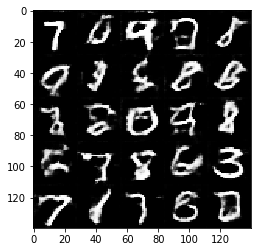

Step 525/128 Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 1.0888
Step 550/128 Epoch 1/2... Discriminator Loss: 1.3099... Generator Loss: 1.7013
Step 575/128 Epoch 1/2... Discriminator Loss: 1.6102... Generator Loss: 0.4029
Step 600/128 Epoch 1/2... Discriminator Loss: 1.5106... Generator Loss: 1.4843


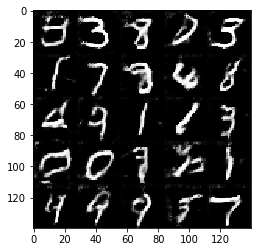

Step 625/128 Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 1.2998
Step 650/128 Epoch 1/2... Discriminator Loss: 1.5095... Generator Loss: 0.5283
Step 675/128 Epoch 1/2... Discriminator Loss: 1.2664... Generator Loss: 1.0803
Step 700/128 Epoch 1/2... Discriminator Loss: 1.4887... Generator Loss: 0.4467


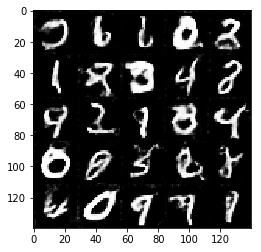

Step 725/128 Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 0.5042
Step 750/128 Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 1.0514
Step 775/128 Epoch 1/2... Discriminator Loss: 1.4118... Generator Loss: 0.5765
Step 800/128 Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 0.4748


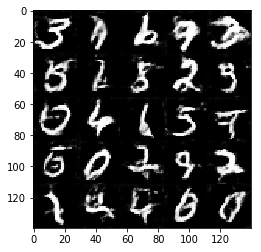

Step 825/128 Epoch 1/2... Discriminator Loss: 1.4602... Generator Loss: 0.5849
Step 850/128 Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 0.5563
Step 875/128 Epoch 1/2... Discriminator Loss: 1.5713... Generator Loss: 0.4215
Step 900/128 Epoch 1/2... Discriminator Loss: 1.1684... Generator Loss: 0.7844


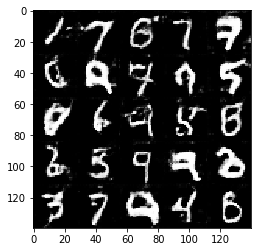

Step 925/128 Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.7267
Step 950/128 Epoch 2/2... Discriminator Loss: 1.5944... Generator Loss: 0.4059
Step 975/128 Epoch 2/2... Discriminator Loss: 1.6465... Generator Loss: 0.3739
Step 1000/128 Epoch 2/2... Discriminator Loss: 1.2067... Generator Loss: 1.1817


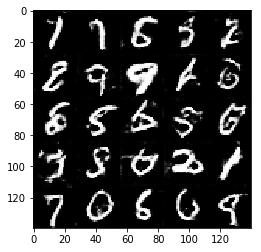

Step 1025/128 Epoch 2/2... Discriminator Loss: 1.5263... Generator Loss: 0.4338
Step 1050/128 Epoch 2/2... Discriminator Loss: 1.1920... Generator Loss: 0.8105
Step 1075/128 Epoch 2/2... Discriminator Loss: 1.5496... Generator Loss: 0.4828
Step 1100/128 Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.5236


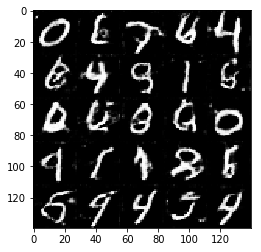

Step 1125/128 Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.5634
Step 1150/128 Epoch 2/2... Discriminator Loss: 1.4969... Generator Loss: 0.5061
Step 1175/128 Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 1.1849
Step 1200/128 Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.8529


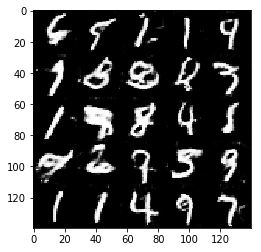

Step 1225/128 Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 1.6304
Step 1250/128 Epoch 2/2... Discriminator Loss: 1.2882... Generator Loss: 2.0075
Step 1275/128 Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 1.5650
Step 1300/128 Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.5976


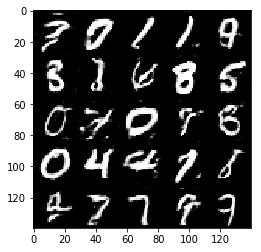

Step 1325/128 Epoch 2/2... Discriminator Loss: 1.3836... Generator Loss: 1.2559
Step 1350/128 Epoch 2/2... Discriminator Loss: 1.4671... Generator Loss: 0.4765
Step 1375/128 Epoch 2/2... Discriminator Loss: 1.4401... Generator Loss: 1.3505
Step 1400/128 Epoch 2/2... Discriminator Loss: 1.4768... Generator Loss: 0.4983


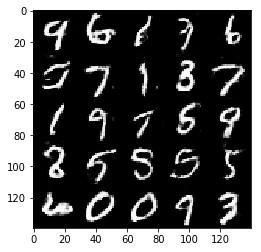

Step 1425/128 Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.9892
Step 1450/128 Epoch 2/2... Discriminator Loss: 1.7574... Generator Loss: 0.3730
Step 1475/128 Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 0.7169
Step 1500/128 Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 1.2694


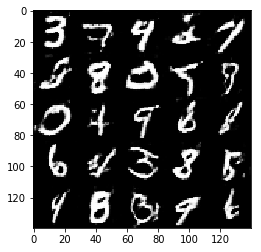

Step 1525/128 Epoch 2/2... Discriminator Loss: 1.4867... Generator Loss: 0.4372
Step 1550/128 Epoch 2/2... Discriminator Loss: 1.1193... Generator Loss: 1.5056
Step 1575/128 Epoch 2/2... Discriminator Loss: 1.6142... Generator Loss: 0.4058
Step 1600/128 Epoch 2/2... Discriminator Loss: 1.1502... Generator Loss: 0.9044


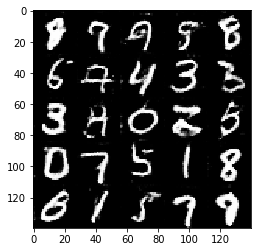

Step 1625/128 Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 0.9215
Step 1650/128 Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.7338
Step 1675/128 Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 1.2363
Step 1700/128 Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.6075


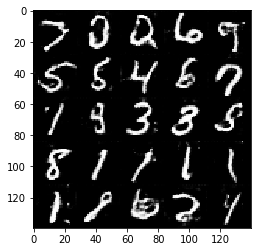

Step 1725/128 Epoch 2/2... Discriminator Loss: 1.1675... Generator Loss: 1.2964
Step 1750/128 Epoch 2/2... Discriminator Loss: 1.3685... Generator Loss: 0.5614
Step 1775/128 Epoch 2/2... Discriminator Loss: 1.4578... Generator Loss: 0.5009
Step 1800/128 Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 0.5071


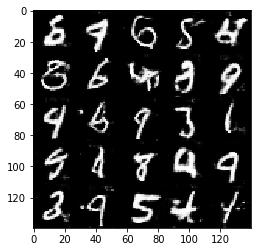

Step 1825/128 Epoch 2/2... Discriminator Loss: 1.1909... Generator Loss: 0.8386
Step 1850/128 Epoch 2/2... Discriminator Loss: 1.1896... Generator Loss: 1.0486


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 25/64 Epoch 1/1... Discriminator Loss: 0.6471... Generator Loss: 3.3022
Step 50/64 Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 2.3629
Step 75/64 Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8014
Step 100/64 Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.8855


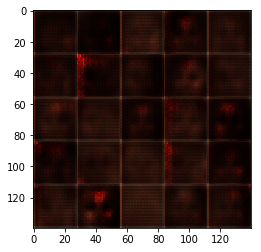

Step 125/64 Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.9860
Step 150/64 Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 1.1788
Step 175/64 Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 1.0985
Step 200/64 Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6779


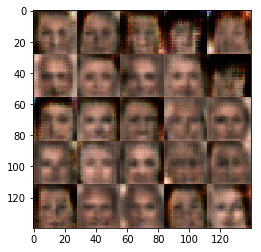

Step 225/64 Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 0.5890
Step 250/64 Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.8400
Step 275/64 Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6958
Step 300/64 Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8829


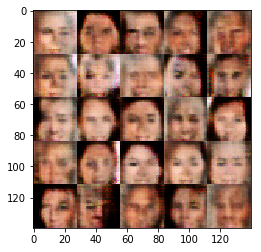

Step 325/64 Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 1.1475
Step 350/64 Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6060
Step 375/64 Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 1.0630
Step 400/64 Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 1.0894


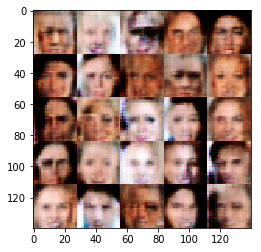

Step 425/64 Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 1.3385
Step 450/64 Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.7539
Step 475/64 Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 1.0247
Step 500/64 Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6806


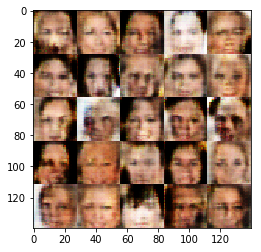

Step 525/64 Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.9988
Step 550/64 Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 1.0832
Step 575/64 Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8640
Step 600/64 Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.9080


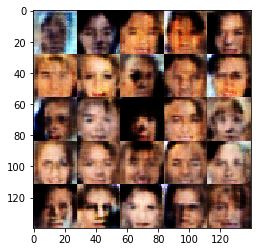

Step 625/64 Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 0.8310
Step 650/64 Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 0.7211
Step 675/64 Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.5781
Step 700/64 Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.4473


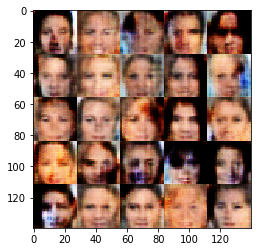

Step 725/64 Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.8833
Step 750/64 Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7821
Step 775/64 Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 1.2211
Step 800/64 Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.6124


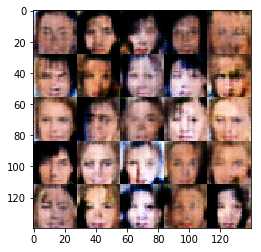

Step 825/64 Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8445
Step 850/64 Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6782
Step 875/64 Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.7704
Step 900/64 Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8337


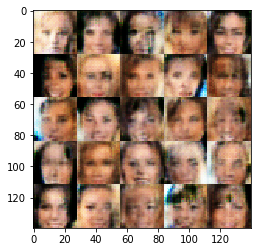

Step 925/64 Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 1.1054
Step 950/64 Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.3707
Step 975/64 Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7897
Step 1000/64 Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 1.1508


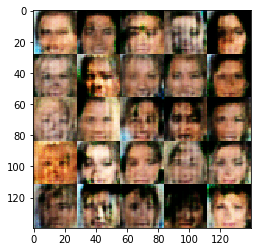

Step 1025/64 Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.8910
Step 1050/64 Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 1.2972
Step 1075/64 Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.8870
Step 1100/64 Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6547


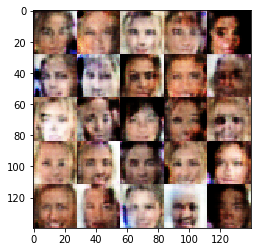

Step 1125/64 Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.8785
Step 1150/64 Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.8933
Step 1175/64 Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 0.8831
Step 1200/64 Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.4344


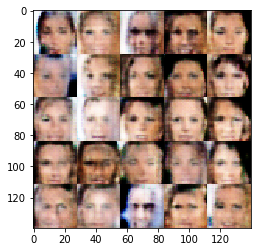

Step 1225/64 Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.8134
Step 1250/64 Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 1.0283
Step 1275/64 Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.6517
Step 1300/64 Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.7201


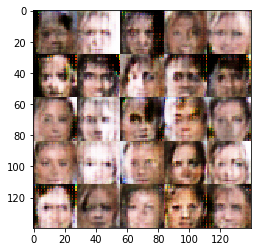

Step 1325/64 Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.5993
Step 1350/64 Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7096
Step 1375/64 Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.5620
Step 1400/64 Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.6482


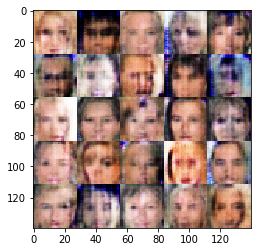

Step 1425/64 Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.8241
Step 1450/64 Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7657
Step 1475/64 Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8241
Step 1500/64 Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7210


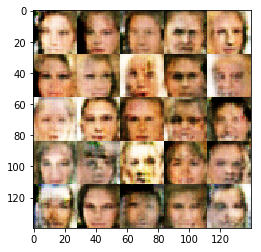

Step 1525/64 Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.6815
Step 1550/64 Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.6555
Step 1575/64 Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6436
Step 1600/64 Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.7897


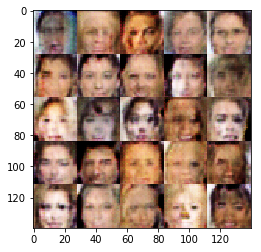

Step 1625/64 Epoch 1/1... Discriminator Loss: 1.7263... Generator Loss: 0.4671
Step 1650/64 Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6983
Step 1675/64 Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8674
Step 1700/64 Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8660


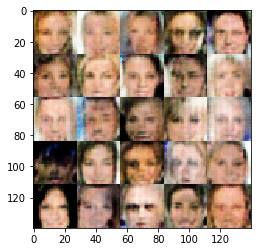

Step 1725/64 Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7605
Step 1750/64 Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6154
Step 1775/64 Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.0975
Step 1800/64 Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.7802


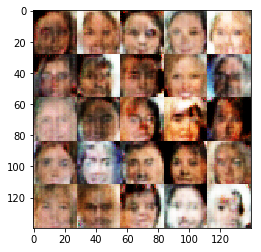

Step 1825/64 Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.7405
Step 1850/64 Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.8766
Step 1875/64 Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7669
Step 1900/64 Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.7973


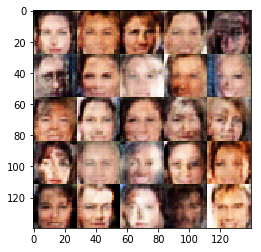

Step 1925/64 Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.6932
Step 1950/64 Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7786
Step 1975/64 Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7202
Step 2000/64 Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.6603


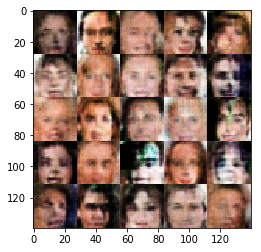

Step 2025/64 Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.9932
Step 2050/64 Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8501
Step 2075/64 Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.6884
Step 2100/64 Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8865


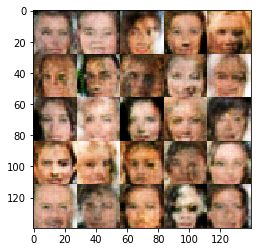

Step 2125/64 Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.8897
Step 2150/64 Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8478
Step 2175/64 Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.8126
Step 2200/64 Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7522


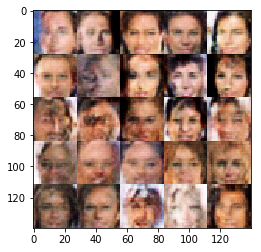

Step 2225/64 Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7537
Step 2250/64 Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7495
Step 2275/64 Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7852
Step 2300/64 Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7352


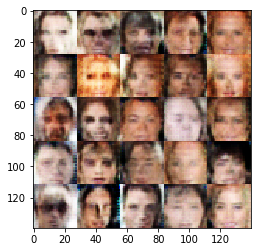

Step 2325/64 Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.6755
Step 2350/64 Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.7271
Step 2375/64 Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.7703
Step 2400/64 Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8173


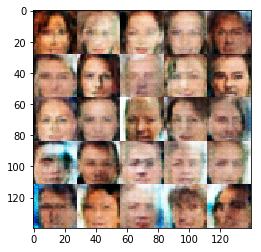

Step 2425/64 Epoch 1/1... Discriminator Loss: 1.3519... Generator Loss: 0.7826
Step 2450/64 Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7108
Step 2475/64 Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7022
Step 2500/64 Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.5697


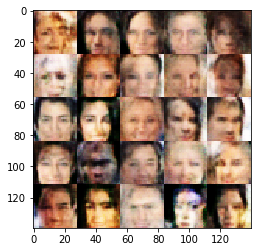

Step 2525/64 Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.7672
Step 2550/64 Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.6617
Step 2575/64 Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.8154
Step 2600/64 Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7422


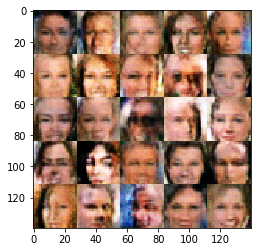

Step 2625/64 Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.7900
Step 2650/64 Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7967
Step 2675/64 Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.6752
Step 2700/64 Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8372


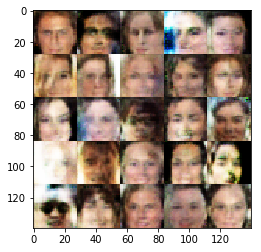

Step 2725/64 Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.7768
Step 2750/64 Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6826
Step 2775/64 Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7915
Step 2800/64 Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7282


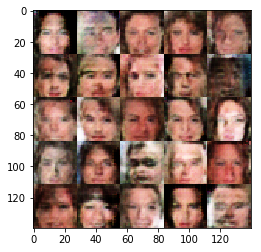

Step 2825/64 Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.8939
Step 2850/64 Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7462
Step 2875/64 Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7898
Step 2900/64 Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7738


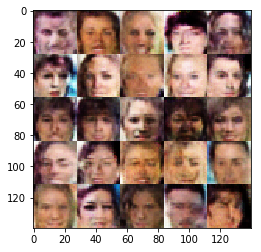

Step 2925/64 Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.6763
Step 2950/64 Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.7758
Step 2975/64 Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7519
Step 3000/64 Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.6988


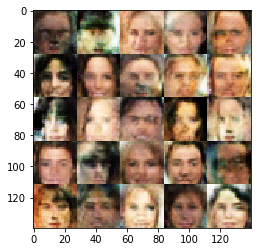

Step 3025/64 Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6109
Step 3050/64 Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.7425
Step 3075/64 Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6720
Step 3100/64 Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7127


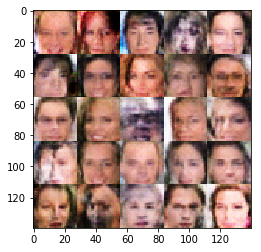

Step 3125/64 Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8608
Step 3150/64 Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.9303


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.